# **Group 9444 Pro Max**

## **Table of Contents**


1.   列表项
2.   列表项



# **Introduction**

## **Project Objectives**

## **新段落**

# **Environment**

## **Install**

In [2]:
!pip install pycocotools

## **Import**

In [88]:
import os
import cv2
import json
import random
import numpy as np
import pandas as pd
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter, CenterCrop, ToTensor, Normalize
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pycocotools.coco import COCO
from PIL import Image

## **Data**

In [19]:
from google.colab import drive
drive.mount('/content/drive')
BASE_PATH= '/content/drive/MyDrive/CLIP_prefix_caption/data/coco'
train_img_path=os.path.join(BASE_PATH,'train2017')
val_img_path=os.path.join(BASE_PATH,'val2017')
anno_path=os.path.join(BASE_PATH,'annotations')
train_ann_path=os.path.join(anno_path,'captions_train2017.json')
val_ann_path=os.path.join(anno_path,'captions_val2017.json')
train_cat_path=os.path.join(anno_path,'instances_train2017.json')
val_cat_path=os.path.join(anno_path,'instances_val2017.json')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
train_ann_path

'/content/drive/MyDrive/CLIP_prefix_caption/data/coco/annotations/captions_train2017.json'

# **Dataset**
The **[COCO](https://cocodataset.org/#home)** (Common Objects in Context）dataset is a large-scale dataset with a diverse range of images from a variety of categories. It designed for object detection, segmentation, and captioning. In this project, we use **COCO 2017 Train/Val** dataset which contains 118K train images, 590K train annotations and 5K val images, 25K val annotations. It contains 80 categories of images, and each image contains 5 annotations.

## **Example**

### Initialization

In [42]:
coco_train=COCO(train_ann_path)
coco_val=COCO(val_ann_path)
cat_train=COCO(train_cat_path)
cat_val=COCO(val_cat_path)
train_id=coco_train.getImgIds()
train_img=coco_train.loadImgs(train_id)
val_id=coco_val.getImgIds()
val_img=coco_val.loadImgs(val_id)

loading annotations into memory...
Done (t=2.08s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=22.99s)
creating index...
index created!
loading annotations into memory...
Done (t=3.56s)
creating index...
index created!


In [61]:
def show_img(id,val=False):
  if val:
    data=coco_val
    file=val_img_path
  else:
    data=coco_train
    file=train_img_path

  annid=data.getAnnIds(id)
  anns=data.loadAnns(annid)
  data.showAnns(anns)
  img_path=os.path.join(file,"{:012d}.jpg".format(id))
  pic=cv2.imread(img_path)
  plt.imshow(pic)
  plt.axis('off')
  plt.show()

### The format of an image in JSON

In [71]:
train_img[5]

{'license': 3,
 'file_name': '000000574769.jpg',
 'coco_url': 'http://images.cocodataset.org/train2017/000000574769.jpg',
 'height': 640,
 'width': 480,
 'date_captured': '2013-11-14 17:07:59',
 'flickr_url': 'http://farm8.staticflickr.com/7010/6728227647_3d5a0d55ee_z.jpg',
 'id': 574769}

### The format of an annotation in JSON

In [70]:
ann_id=coco_train.getAnnIds(train_id[5])
anns=coco_train.loadAnns(ann_id)
anns

[{'image_id': 574769,
  'id': 561237,
  'caption': 'A woman in a room with a cat.'},
 {'image_id': 574769,
  'id': 562344,
  'caption': 'A girl smiles as she holds a cat and wears a brightly colored skirt.'},
 {'image_id': 574769,
  'id': 564249,
  'caption': 'a woman is holding a cat in her kitchen'},
 {'image_id': 574769,
  'id': 564444,
  'caption': 'A woman is working in a kitchen carrying a soft toy.'},
 {'image_id': 574769,
  'id': 564477,
  'caption': 'A woman is holding a cat in her kitchen.'}]

### The format of a category in JSON

In [82]:
cat_id=cat_train.getCatIds()
print(cat_train.loadCats(cat_id[1]))


[{'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}]


### The image with five caption

A woman in a room with a cat.
A girl smiles as she holds a cat and wears a brightly colored skirt.
a woman is holding a cat in her kitchen
A woman is working in a kitchen carrying a soft toy.
A woman is holding a cat in her kitchen.


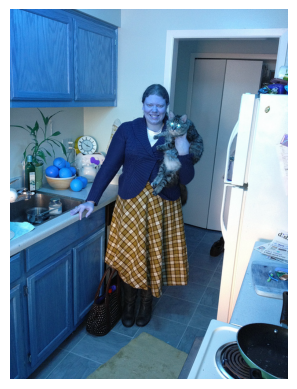

In [68]:
show_img(train_id[5])

# **Preprocessing**
Our preprocessing consists of text preprocessing and image preprocessing

## **Text Preprocessing**

We preprocessed the annotations

## **Image preprocessing**

We will modify the preprocessing function of the image to improve model performance. Preprocessing includes:
*   **Random Horizontal Flip:**
The image will be randomly flipped horizontally with a value as a probability.
*   **Random Vertical Flip:**
The image will be randomly flipped vertically with a value as a probability.
*   **CLAHE(Contrast Limited Adaptive Histogram Equalization):**
Enhance local contrast in images and capture dark and light details of an image
*   **Convert Image To RGB:**
Ensure that all input images are in the RGB color space
*   **Other:**
Includes resizing the image to a fixed size, centering the crop to focus on the central region, normalizing pixel values to a standard range for model compatibility, and converting the image to a tensor format.


```
n_px=224
def _transform(n_px):
    return Compose([
        Resize(n_px, interpolation=BICUBIC),
        RandomHorizontalFlip(0.2),
        RandomVerticalFlip(0.1),
        CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8)),
        CenterCrop(n_px),
        _convert_image_to_rgb,
        ToTensor(),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])
def _convert_image_to_rgb(image):
    return image.convert("RGB")

```
By preprocessing the image, we can improve the robustness of the model and reduce overfitting, which is beneficial for the model to recognize the light and dark features in the image, and improves the model performance, so that the model can better recognize the image from all angles.

The following is a demonstration of some of the preprocessing steps.

**Random Horizontal and Vertical Flip:**We set it to flip horizontally with a probability of 0.2 and vertically with a probability of 0.1, which means that close to 20% and 10% of the image will be flipped horizontally or vertically, and 2% will be flipped both .

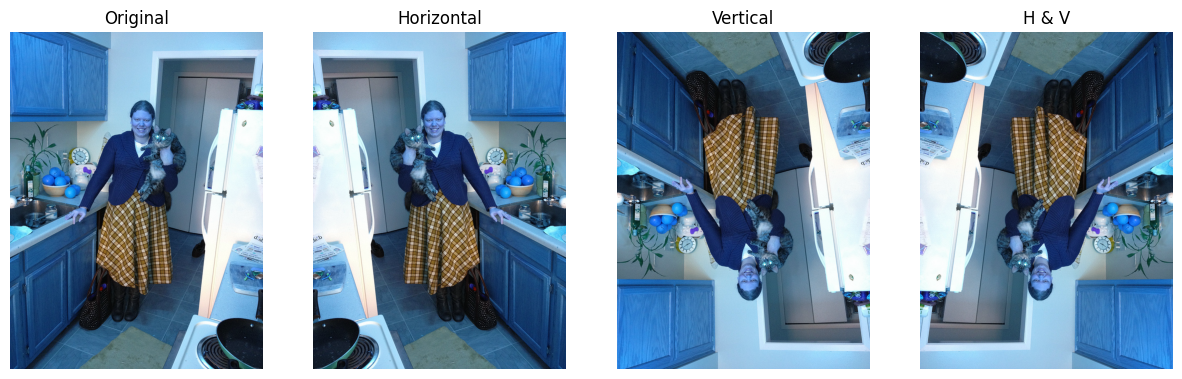

In [91]:
fig,axs=plt.subplots(1,4,figsize=(15,5))

process1=RandomHorizontalFlip(1)
process2=RandomVerticalFlip(1)
process3=Compose([RandomHorizontalFlip(1),RandomVerticalFlip(1)])
id=train_id[5]
img_path=os.path.join(train_img_path,"{:012d}.jpg".format(id))
image=cv2.imread(img_path)
image = Image.fromarray(image)
image1=process1(image)
image2=process2(image)
image3=process3(image)

axs[0].imshow(image)
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(image1)
axs[1].set_title('Horizontal')
axs[1].axis('off')
axs[2].imshow(image2)
axs[2].set_title('Vertical')
axs[2].axis('off')
axs[3].imshow(image3)
axs[3].set_title('H & V')
axs[3].axis('off')

plt.show()

**CLAHE(Contrast Limited Adaptive Histogram Equalization):**CLAHE processes small areas of the image to make the overall contrast of the image more balanced by limiting the contrast, and the visibility of detailed features is increased.

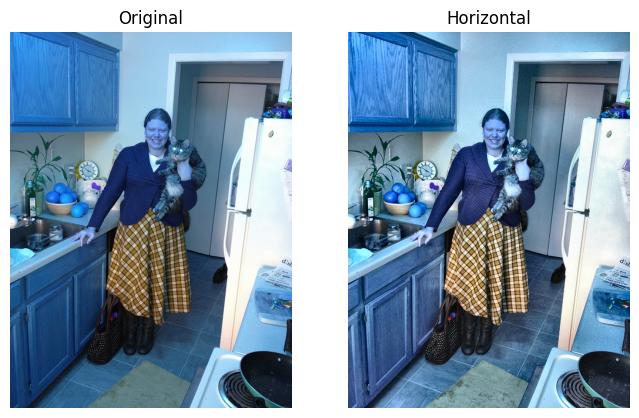

In [94]:
class CLAHETransform(object):
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    def __call__(self, img):
        img = np.array(img)  # Convert PIL image to numpy array
        if len(img.shape) == 2:  # If image is grayscale
            img = self.clahe.apply(img)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(img)
            l = self.clahe.apply(l)
            img = cv2.merge((l, a, b))
            img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
        img = Image.fromarray(img)  # Convert numpy array back to PIL image
        return img

process4=CLAHETransform()
image4=process4(image)

fig,axs=plt.subplots(1,2,figsize=(8,5))
axs[0].imshow(image)
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(image4)
axs[1].set_title('Horizontal')
axs[1].axis('off')
plt.show()

We can see the details in its darker areas become brighter, such as the bag around the feet.

# **新段落**

## 新段落